# Tuberculosis Detection - Tensorflow

## Import and Define Constants

In [1]:
# Import all needed libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16 
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image
from sklearn.model_selection import train_test_split

from utils import load_dataframe

#Configure memory usage to the GPU device
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-06-03 18:42:23.169634: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-03 18:42:24.446303: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-03 18:42:24.446841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-03 18:42:24.480973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 18:42:24.481103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 119.24GiB/s
2022-06-03 18:42:24.481121: I tensorflow/stream_executor/platform/def

In [2]:
INPUT_SHAPE = (300,300,3)
# IMG_SIZE = (224,224)
IMG_SIZE = (300,300)
BATCH_SIZE = 12
VAL_SIZE = 0.2
SEED = 42
CHECKPOINT_PATH = 'model/epoch-{epoch}_valloss-{val_loss:.4f}.hdf5'
EPOCHS = 30
# EPOCHS = 3 # To test whether the model has learned

In [3]:
dataset_description_path = "dataset_description.yaml"

## Generate the dataframe and split in train/val and test

In [4]:
#Generate dataset from description
tb_df = load_dataframe(dataset_description_path)

In [5]:
tb_df

,file,path,abnormal,tuberculosis
0,00000562_000.png,dataset/anormal-xr-no_tb/00000562_000.png,1,0
1,00000199_002.png,dataset/anormal-xr-no_tb/00000199_002.png,1,0
2,00000628_000.png,dataset/anormal-xr-no_tb/00000628_000.png,1,0
3,00000897_000.png,dataset/anormal-xr-no_tb/00000897_000.png,1,0
4,00000830_006.png,dataset/anormal-xr-no_tb/00000830_006.png,1,0
...,...,...,...,...
15753,Tuberculosis-49.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
15754,Tuberculosis-127.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
15755,Tuberculosis-166.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
15756,Tuberculosis-237.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1


In [6]:
def sampling_k_elements(group, k=1500):
    if len(group) < k:
        return group
    return group.sample(k)

tb_df  = tb_df.groupby('tuberculosis').apply(sampling_k_elements).reset_index(drop=True)

In [7]:
tb_df

,file,path,abnormal,tuberculosis
0,00001248_011.png,dataset/anormal-xr-no_tb/00001248_011.png,1,0
1,person469_bacteria_1994.jpeg,dataset/chest-xr-pnm-cvd19-tb/train/PNEUMONIA/...,1,0
2,00000462_000.png,dataset/anormal-xr-no_tb/00000462_000.png,1,0
3,Normal-313.png,dataset/TB_Chest_Radiography_Database/Normal/N...,0,0
4,person545_bacteria_2288.jpeg,dataset/chest-xr-pnm-cvd19-tb/train/PNEUMONIA/...,1,0
...,...,...,...,...
2898,Tuberculosis-49.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
2899,Tuberculosis-127.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
2900,Tuberculosis-166.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
2901,Tuberculosis-237.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1


In [8]:
tb_df[tb_df['abnormal']==1].count()

file            2349
path            2349
abnormal        2349
tuberculosis    2349
dtype: int64

In [9]:
train_df, test_df = train_test_split(tb_df, test_size=0.1)

In [10]:
train_df

,file,path,abnormal,tuberculosis
493,00000841_001.png,dataset/anormal-xr-no_tb/00000841_001.png,1,0
1638,Tuberculosis-503.png,dataset/chest-xr-pnm-cvd19-tb/train/TURBERCULO...,1,1
2206,Tuberculosis-679.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
134,00001148_001.png,dataset/anormal-xr-no_tb/00001148_001.png,1,0
1558,Tuberculosis-636.png,dataset/chest-xr-pnm-cvd19-tb/train/TURBERCULO...,1,1
...,...,...,...,...
2697,Tuberculosis-548.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
45,Normal-1125.png,dataset/TB_Chest_Radiography_Database/Normal/N...,0,0
1691,Tuberculosis-48.png,dataset/chest-xr-pnm-cvd19-tb/train/TURBERCULO...,1,1
1415,00001200_022.png,dataset/anormal-xr-no_tb/00001200_022.png,1,0


In [11]:
test_df

,file,path,abnormal,tuberculosis
2220,Tuberculosis-508.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
2397,Tuberculosis-227.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
247,person1473_virus_2553.jpeg,dataset/chest-xr-pnm-cvd19-tb/train/PNEUMONIA/...,1,0
1306,00001297_001.png,dataset/anormal-xr-no_tb/00001297_001.png,1,0
2841,Tuberculosis-185.png,dataset/TB_Chest_Radiography_Database/Tubercul...,1,1
...,...,...,...,...
131,IM-0003-0001.jpeg,dataset/chest-xr-pnm-cvd19-tb/test/NORMAL/IM-0...,0,0
2012,Tuberculosis-300.png,dataset/chest-xr-pnm-cvd19-tb/train/TURBERCULO...,1,1
1486,person70_bacteria_344.jpeg,dataset/chest-xr-pnm-cvd19-tb/train/PNEUMONIA/...,1,0
1493,00001317_003.png,dataset/anormal-xr-no_tb/00001317_003.png,1,0


## Create the Data Generators with Data Augmentation

In [12]:
#Creates the image data generator using the ResNet50 preprocess and make the pixel values be between 0 and 1
train_generator = ImageDataGenerator(
    # preprocessing_function = preprocess_input_vgg16,
    preprocessing_function=preprocess_input_resnet50,
    rescale = 1./255,
    validation_split = VAL_SIZE)

test_generator = ImageDataGenerator(
    # preprocessing_function=preprocess_input_vgg16,
    preprocessing_function=preprocess_input_resnet50,
    rescale = 1./255)

In [13]:
#To optimize the RAM usage, we use the flow method from generator continuously provide images

train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = '',
    x_col = 'path',
    y_col = ['abnormal','tuberculosis'],
    # y_col = 'abnormal',
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    class_mode = 'raw',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED,
    subset = 'training',
    # rotation_range = 30,
    # zoom_range = 0.10,
    # width_shift_range = 0.1,
    # height_shift_range = 0.1,
    # shear_range = 0.15,
    # horizontal_flip = True,
    # vertical_flip = True,
    fill_mode = "nearest")

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = '',
    x_col = 'path',
    y_col = ['abnormal','tuberculosis'],
    # y_col = 'abnormal',
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    class_mode = 'raw',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED,
    subset = 'validation',
    # rotation_range = 30,
    # zoom_range = 0.10,
    # width_shift_range = 0.1,
    # height_shift_range = 0.1,
    # shear_range = 0.15,
    # horizontal_flip = True,
    # vertical_flip = True,
    fill_mode = "nearest")

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    directory = '',
    x_col = 'path',
    y_col = ['abnormal','tuberculosis'],
    # y_col = 'abnormal',
    target_size = IMG_SIZE,
    color_mode = 'rgb',
    class_mode = None,
    batch_size = BATCH_SIZE,
    shuffle=False)

Found 2090 validated image filenames.
Found 522 validated image filenames.
Found 291 validated image filenames.


## Train the model and define the metrics functions

In [14]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
# Load the Resnet 50 with its tops layers
resnet50 = ResNet50(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

# vgg16 = VGG16(
#     input_shape = INPUT_SHAPE,
#     include_top = False,
#     weights = 'imagenet',
#     pooling = 'avg'
# )

2022-06-03 18:42:24.825973: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-03 18:42:24.826462: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-03 18:42:24.826642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 18:42:24.826786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.56GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 119.24Gi

In [16]:
#The ResNet model it is without the top layers so we customize to fits our needs
# inputs = vgg16.input
inputs = resnet50.input


# layer = Dense(128, activation='relu')(vgg16.output)
layer = Dense(128, activation='relu')(resnet50.output)
layer = Dense(128, activation='relu')(layer)

outputs = Dense(2, activation='sigmoid')(layer)

model = Model(inputs = inputs, outputs = outputs)

# model.compile(
#     optimizer='adam',
#     # loss=['binary_crossentropy','binary_crossentropy'],
#     loss='binary_crossentropy',
#     metrics=['accuracy',f1_score,precision_m, recall_m])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              # loss=tf.keras.losses.BinaryCrossentropy(),
              loss=[tf.keras.losses.Hinge(),tf.keras.losses.Hinge()],
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives(),
                       f1_score,
                       precision_m,
                       recall_m])


In [17]:
#Defines the callbacks to use during training

#Reduces learning rate on plateou
reduceLROnplateou = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.001)

#stops training when the validation loss doesn't improve
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights = True)

#Saves the model checkpoint each time the validation loss improves
checkPoint = ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    monitor='val_loss',
    save_best_only=True)

callbacks = [reduceLROnplateou, earlyStopping, checkPoint]

In [18]:
#Trains the model and saves the training history
history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = EPOCHS,
    steps_per_epoch = len(train_images),
    validation_steps = len(val_images),
    callbacks = callbacks,
    workers = 6
)

2022-06-03 18:42:26.267424: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-03 18:42:26.284136: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/30


2022-06-03 18:42:29.826986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-03 18:42:30.121876: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-03 18:42:30.991951: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-06-03 18:42:31.076932: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-06-03 18:42:32.122172: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-03 18:4

175/175 [==============================] - 145s 677ms/step - loss: 0.5206 - binary_accuracy: 0.8290 - false_negatives: 97.3125 - f1_score: 0.8728 - precision_m: 0.8349 - recall_m: 0.9277 - val_loss: 0.7663 - val_binary_accuracy: 0.6169 - val_false_negatives: 0.0000e+00 - val_f1_score: 0.7540 - val_precision_m: 0.6165 - val_recall_m: 1.0000
Epoch 2/30
175/175 [==============================] - 85s 482ms/step - loss: 0.4895 - binary_accuracy: 0.8616 - false_negatives: 51.6875 - f1_score: 0.8966 - precision_m: 0.8425 - recall_m: 0.9687 - val_loss: 0.7663 - val_binary_accuracy: 0.6169 - val_false_negatives: 0.0000e+00 - val_f1_score: 0.7577 - val_precision_m: 0.6174 - val_recall_m: 1.0000
Epoch 3/30
175/175 [==============================] - 85s 483ms/step - loss: 0.5259 - binary_accuracy: 0.8285 - false_negatives: 85.5227 - f1_score: 0.8710 - precision_m: 0.8172 - recall_m: 0.9487 - val_loss: 0.7663 - val_binary_accuracy: 0.6169 - val_false_negatives: 0.0000e+00 - val_f1_score: 0.7562 - v

## Plot the Loss and Accuracy

In [19]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'false_negatives', 'f1_score', 'precision_m', 'recall_m', 'val_loss', 'val_binary_accuracy', 'val_false_negatives', 'val_f1_score', 'val_precision_m', 'val_recall_m', 'lr'])

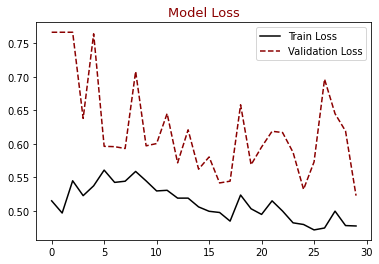

In [20]:
plt.figure()
plt.plot(history.history["loss"],label = "Train Loss", color = "black")
plt.plot(history.history["val_loss"],label = "Validation Loss", color = "darkred", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Loss", color = "darkred", size = 13)
plt.legend()
plt.show()

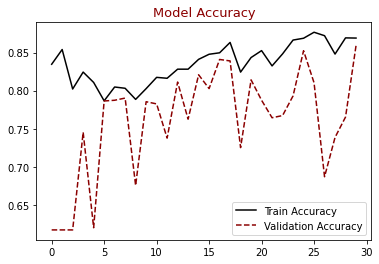

In [21]:
plt.figure()
plt.plot(history.history["binary_accuracy"],label = "Train Accuracy", color = "black")
plt.plot(history.history["val_binary_accuracy"],label = "Validation Accuracy", color = "darkred", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Accuracy", color = "darkred", size = 13)
plt.legend()
plt.show()

## Load the best model to perform inference

In [22]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [24]:
dependencies = {
    'f1_score': f1_score,
    'precision_m': precision_m,
    'recall_m': recall_m
}
model_pred = load_model('model/epoch-30_valloss-0.5229.hdf5', custom_objects=dependencies)

In [25]:
pred = model_pred.predict(
    test_images,
    steps = len(test_images),
    workers = 6)

In [26]:
y_test = list(test_df[['abnormal','tuberculosis']].values.tolist())

In [31]:
round_pred = []
for i in pred:
    round_pred.append([round(i[0]),round(i[1])])

In [33]:
class_report = classification_report(y_test, round_pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       239
           1       0.94      0.96      0.95       141

   micro avg       0.86      0.98      0.92       380
   macro avg       0.88      0.98      0.93       380
weighted avg       0.87      0.98      0.92       380
 samples avg       0.81      0.99      0.81       380



In [ ]:
# y_test = list(test_df[['abnormal','tuberculosis']])
# acc = accuracy_score(y_test,pred)
# print(f'Accuracy on the test set: {acc * 100:.2f}%')

In [30]:
round(0.9)

1

In [32]:
round_pred

[[1, 1],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 1],
 [1, 0],
 